<a href="https://colab.research.google.com/github/Anand-Deekshit/Model-Photosphere/blob/main/Model_Photosphere_(Number_Densities).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL PHOTOSPHERE (NUMBER DENSITES)

## Import the required libraries and the properties of the star

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.pyplot import cm
from scipy import interpolate
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.special as special
import math
K = 1.38 * 10 ** (-16)
log_g = 4.44
metallicity = 0
g = 10 ** log_g


## Read the grid from the file and store the mass and temperatures

In [ ]:
with open('kurucz.txt') as f:
  lines = f.readlines()

masses = []
temps = []
for line in lines[2:]:
  masses.append(float(line.split("       ")[0]))
  temps.append(float(line.split("       ")[1][:-1]))


## The Total Pressure is the mass column times g and the radiation pressure is given by the temperature. The radiation pressure is extremely small so you can ignore it if you want to. We can get P${_g}$ by subtracting the radiation pressure from the total pressure.

In [ ]:
total_p = []
radiation_p = []

for mass in masses:
  total_p.append(mass * g)

for temp in temps:
  radiation_p.append(2.52 * 10 ** (-15) * temp ** 4)

P_g = [total_p[i] - radiation_p[i] for i in range(len(total_p))]

## Input all the partition function values, abundances and the ionization potentials for the elements of interest.

In [ ]:

element_name = {
    'H': 'Hydrogen',
    'He': 'Helium',
    'C': 'Carbon',
    'Si': 'Silicon',
    'Fe': 'Iron',
    'Mg': 'Magnesium',
    'Ni': 'Nickle',
    'Cr': 'Chromium',
    'Ca': 'Calcium',
    'K': 'Potassium',
    'Na': 'Sodium'
}

log_partition_fn = {
    'H-': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'H': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.301, 0.4: 0.303},
    'H+': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'He': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'He+': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.301, 0.4: 0.301},
    'C': {1.4: 0.954, 1.2: 0.958, 1.0: 0.964, 0.8: 0.975, 0.6: 0.994, 0.4: 1.037},
    'C+': {1.4: 0.771, 1.2: 0.772, 1.0: 0.773, 0.8: 0.774, 0.6: 0.775, 0.4: 0.782},
    'Si': {1.4: 0.949, 1.2: 0.961, 1.0: 0.976, 0.8: 0.996, 0.6: 1.030, 0.4: 1.111},
    'Si+': {1.4: 0.746, 1.2: 0.750, 1.0: 0.755, 0.8: 0.759, 0.6: 0.764, 0.4: 0.778},
    'Fe': {1.4: 1.372, 1.2: 1.402, 1.0: 1.446, 0.8: 1.519, 0.6: 1.664, 0.4: 2.049},
    'Fe+': {1.4: 1.575, 1.2: 1.604, 1.0: 1.638, 0.8: 1.682, 0.6: 1.749, 0.4: 1.881},
    'Mg': {1.4: 0.001, 1.2: 0.002, 1.0: 0.007, 0.8: 0.027, 0.6: 0.110, 0.4: 0.478},
    'Mg+': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.304, 0.4: 0.326},
    'Ni': {1.4: 1.447, 1.2: 1.467, 1.0: 1.490, 0.8: 1.521, 0.6: 1.577, 0.4: 1.753},
    'Ni+': {1.4: 0.953, 1.2: 0.988, 1.0: 1.037, 0.8: 1.108, 0.6: 1.215, 0.4: 1.386},
    'Cr': {1.4: 0.917, 1.2: 0.956, 1.0: 1.022, 0.8: 1.141, 0.6: 1.380, 0.4: 1.977},
    'Cr+': {1.4: 0.793, 1.2: 0.813, 1.0: 0.856, 0.8: 0.944, 0.6: 1.125, 0.4: 1.489},
    'Ca': {1.4: 0.010, 1.2: 0.028, 1.0: 0.073, 0.8: 0.181, 0.6: 0.465, 0.4: 1.332},
    'Ca+': {1.4: 0.309, 1.2: 0.320, 1.0: 0.344, 0.8: 0.391, 0.6: 0.483, 0.4: 0.658},
    'K': {1.4: 0.308, 1.2: 0.320, 1.0: 0.351, 0.8: 0.429, 0.6: 0.642, 0.4: 1.329},
    'K+': {1.4: 0.000, 1.2: 0.000, 1.0: 0.000, 0.8: 0.000, 0.6: 0.000, 0.4: 0.000},
    'Na': {1.4: 0.307, 1.2: 0.309, 1.0: 0.320, 0.8: 0.357, 0.6: 0.493, 0.4: 1.043},
    'Na+': {1.4: 0.000, 1.2: 0.000, 1.0: 0.000, 0.8: 0.000, 0.6: 0.000, 0.4: 0.000},
}


ionization_potential = {
    'H': 13.598,
    'H-': 0.754,
    'He': 24.587,
    'C': 11.260,
    'Si': 8.152,
    'Fe': 7.902,
    'Mg': 7.646,
    'Ni': 7.640,
    'Cr': 6.767,
    'Ca': 6.113,
    'K': 4.341,
    'Na': 5.139
}

abundance = {
    'H': 1.00 * 10 ** 0,
    'He': 8.51 * 10 ** (-2),
    'C': 3.31 * 10 ** (-4),
    'Si': 3.55 * 10 ** (-5),
    'Fe': 2.75 * 10 ** (-5),
    'Mg': 3.80 * 10 ** (-5),
    'Ni': 1.78 * 10 ** (-6),
    'Cr': 4.68 * 10 ** (-7),
    'Ca': 2.29 * 10 ** (-6),
    'K': 1.32 * 10 ** (-7),
    'Na': 2.14 * 10 ** (-6)
}

atomic_weight = {
    'H': 1.67 * 10 ** (-24),
    'He': 6.64 * 10 ** (-24),
    'C': 1.99 * 10 ** (-23),
    'Si': 4.66 * 10 ** (-23),
    'Fe': 9.27 * 10 ** (-23),
    'Mg': 4.03 * 10 ** (-23),
    'Ni': 9.74 * 10 ** (-23),
    'Cr': 8.63 * 10 ** (-23),
    'Ca': 6.65 * 10 ** (-23),
    'K': 6.49 * 10 ** (-23),
    'Na': 3.81 * 10 ** (-23)
}



## A function to get the partition function for theta values in between the values given in Gray's book.

In [ ]:
def get_partition_fn(element, theta):
  if theta <= 1.4 and theta >= 1.2:
    return ((10 ** log_partition_fn[element][1.4]) + (10 ** log_partition_fn[element][1.2])) / 2
  elif theta < 1.2 and theta >= 1.0:
    return ((10 ** log_partition_fn[element][1.2])  + (10 ** log_partition_fn[element][1.0])) / 2
  elif theta < 1.0 and theta >= 0.8:
    return ((10 ** log_partition_fn[element][1.0]) + (10 ** log_partition_fn[element][0.8])) / 2
  elif theta < 0.8 and theta >= 0.6:
    return ((10 ** log_partition_fn[element][0.8]) + (10 ** log_partition_fn[element][0.6])) / 2
  elif theta < 0.6 and theta >= 0.4:
    return ((10 ** log_partition_fn[element][0.6]) + (10 ** log_partition_fn[element][0.4])) / 2


## Because the equation has P${_e}$ on both sides it can't be solved in a classical manner. We guess for a value of P${_e}$ and iterate the equaiton multiple times by replacing the old guess with the calculated value to get a good value for P${_e}$ for each point in the grid.

In [ ]:
P_es = []

for i in range(len(temps)):
  P_guess = 1000
  num = 0 # numerator
  den = 0 # denominator
  
  # print(theta)
  for element in abundance.keys():
    for _ in range(1000):
      theta = 5040 / temps[i]
      partition_fn_ionized = get_partition_fn(element + '+', theta)
      partition_fn = get_partition_fn(element, theta)
      
      phi_element = 0.6665 * partition_fn_ionized * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential[element]) / partition_fn

      
      num = num + abundance[element] * (phi_element / P_guess) / (1 + (phi_element / P_guess))
      den = den + abundance[element] * (1 + ((phi_element / P_guess) / (1 + phi_element / P_guess)))
  

      P_e = P_g[i] * num / den
      P_guess = P_e
      
  P_es.append(P_e)

## Plot of the log of number density of e$^{-}$ vs Temperature

Text(0.5, 1.0, 'log(N$_{e}$) vs T')

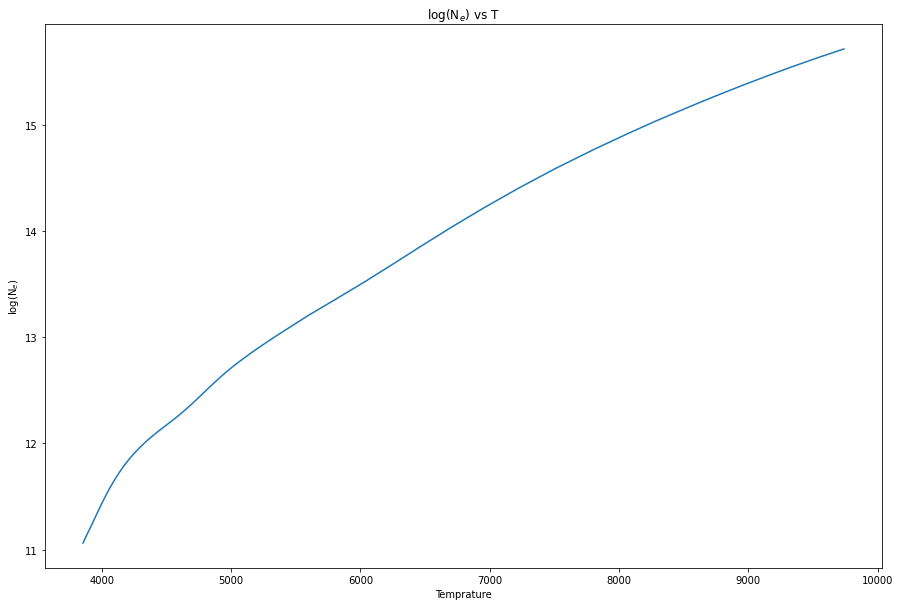

In [ ]:
N_e = [P_es[i] / (K * temps[i]) for i in range(len(temps))]
log_N_e = [math.log10(n) for n in N_e]

plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_e)
plt.xlabel('Temprature')
plt.ylabel('log(N$_{e}$)') # Log of number density of electrons
plt.title('log(N$_{e}$) vs T')

## Now that we have the electron pressures at each point in the grid we can find the total number density using (P${_g}$ - P${_e}$) / KT. 

Text(0.5, 1.0, 'log(N$_{tot}$) vs T')

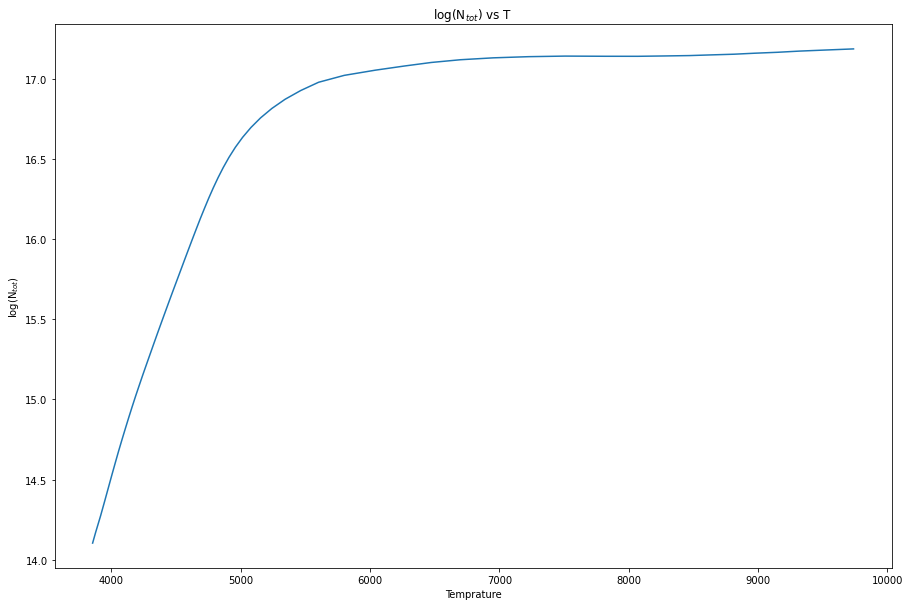

In [ ]:
N_tot = [(P_g[i] - P_es[i]) /  (K * temps[i]) for i in range(len(temps))]
log_N_tot = [math.log10(n) for n in N_tot]

plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_tot)
plt.xlabel('Temprature')
plt.ylabel('log(N$_{tot}$)') # Log of total number density
plt.title('log(N$_{tot}$) vs T')

## Number density of Hydrogen is basically the total number density divided by the sum of the abundances (the definition of abundance).

Text(0.5, 1.0, 'log(N$_{H}$) vs T')

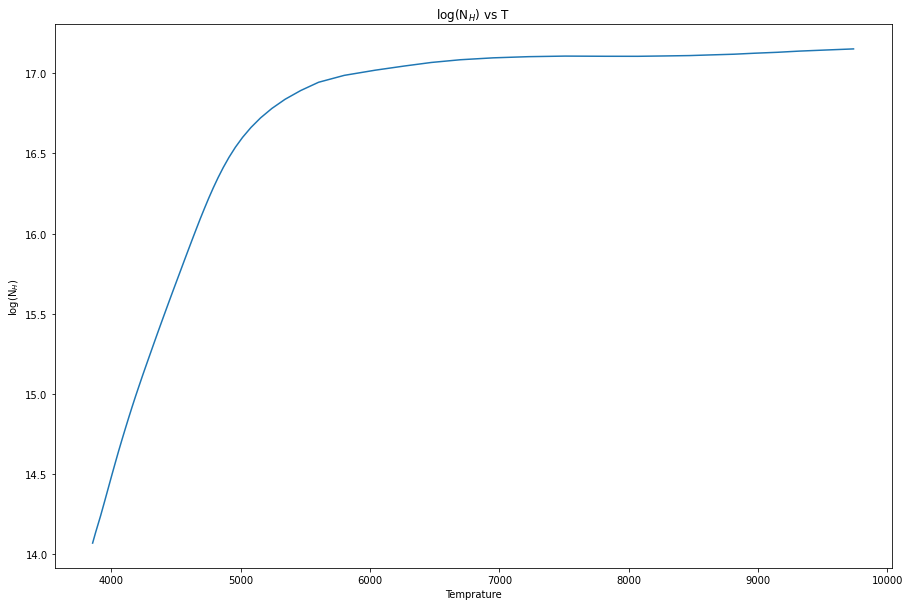

In [ ]:
total_abundance = 0
for element in abundance.keys():
  total_abundance = total_abundance + abundance[element]
N_H = [N_tot[i] / total_abundance for i in range(len(N_tot))]
log_N_H = [math.log10(n) for n in N_H]

plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_H)
plt.xlabel('Temprature')
plt.ylabel('log(N$_{H}$)') # Log of number density of Hydrogen
plt.title('log(N$_{H}$) vs T')

## The ion density is the abundance times N${_H}$ at that temp.

In [ ]:
N_element = {}
for element in abundance:
  number_density = []
  for i in range(len(temps)):
    N = abundance[element] * N_H[i]
    number_density.append(N)
  N_element[element] = number_density

## We also have to include H$^{-}$ which we will get from the Saha Eq.

In [ ]:
N_H_minus = []
for i in range(len(temps)):
  theta = 5040 / temps[i]
  phi_H_minus = 0.6665 * get_partition_fn('H', theta) / get_partition_fn('H-', theta) \
  * 2 * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential['H-'])
  N_H_minus.append(N_H[i] * P_es[i] / phi_H_minus)
log_N_H_minus = [math.log10(n) for n in N_H_minus]

## Hydrogen

Text(0.5, 1.0, 'Hydrogen')

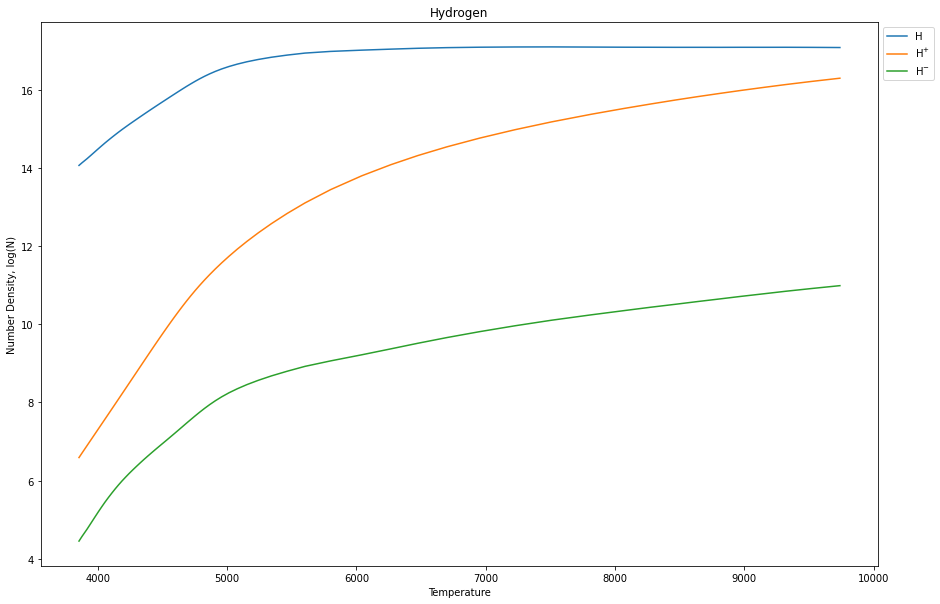

In [ ]:
N_H_neutral = []
N_H_plus = []
for i in range(len(temps)):
  theta = 5040 / temps[i]
  phi = 0.6665 * get_partition_fn('H', theta) / get_partition_fn('H+', theta) \
  * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential['H'])
  n = N_H[i] / (1 + phi / P_es[i])
  N_H_neutral.append(n)
  N_H_plus.append(N_H[i] - n)
log_N_H_neutral = [math.log10(n) for n in N_H_neutral]
log_N_H_plus = [math.log10(n) for n in N_H_plus]
plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_H_neutral)
plt.plot(temps, log_N_H_plus)
plt.plot(temps, log_N_H_minus)
plt.legend(['H', 'H$^{+}$', 'H$^{-}$'], bbox_to_anchor=(1, 1))
plt.xlabel('Temperature')
plt.ylabel('Number Density, log(N)')
plt.title('Hydrogen')

## Helium

Text(0.5, 1.0, 'Helium')

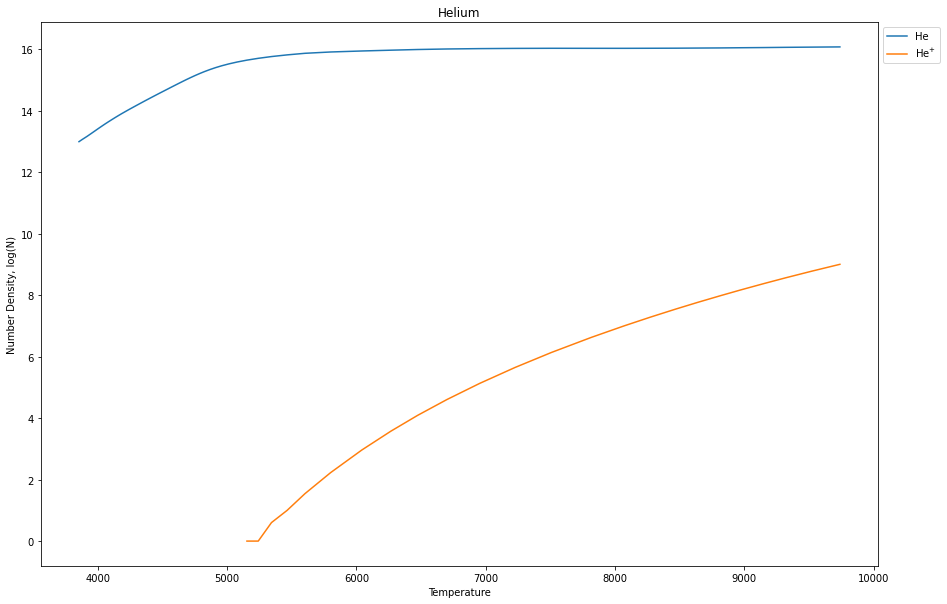

In [ ]:
N_He = N_element['He']
N_He_neutral = []
N_He_plus = []
for i in range(len(temps)):
  theta = 5040 / temps[i]
  phi = 0.6665 * get_partition_fn('He', theta) / get_partition_fn('He+', theta) \
  * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential['He'])
  n = N_He[i] / (1 + phi / P_es[i])
  N_He_neutral.append(n)
  N_He_plus.append(N_He[i] - n)


for i in range(len(N_He_plus)):
  if N_He_plus[i] > 0:
    break

temps_He_plus = temps[i:]
N_He_plus = N_He_plus[i:]
log_N_He_neutral = [math.log10(n) for n in N_He_neutral]
log_N_He_plus = [math.log10(n) for n in N_He_plus]
plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_He_neutral)
plt.plot(temps_He_plus, log_N_He_plus)
plt.legend(['He', 'He$^{+}$'], bbox_to_anchor=(1, 1))
plt.xlabel('Temperature')
plt.ylabel('Number Density, log(N)')
plt.title('Helium')

## Other Metals

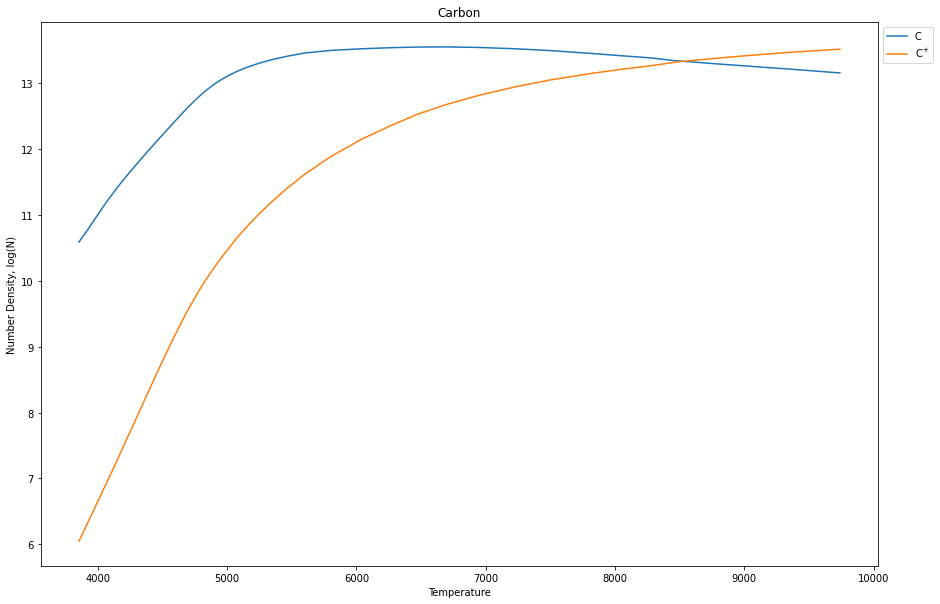

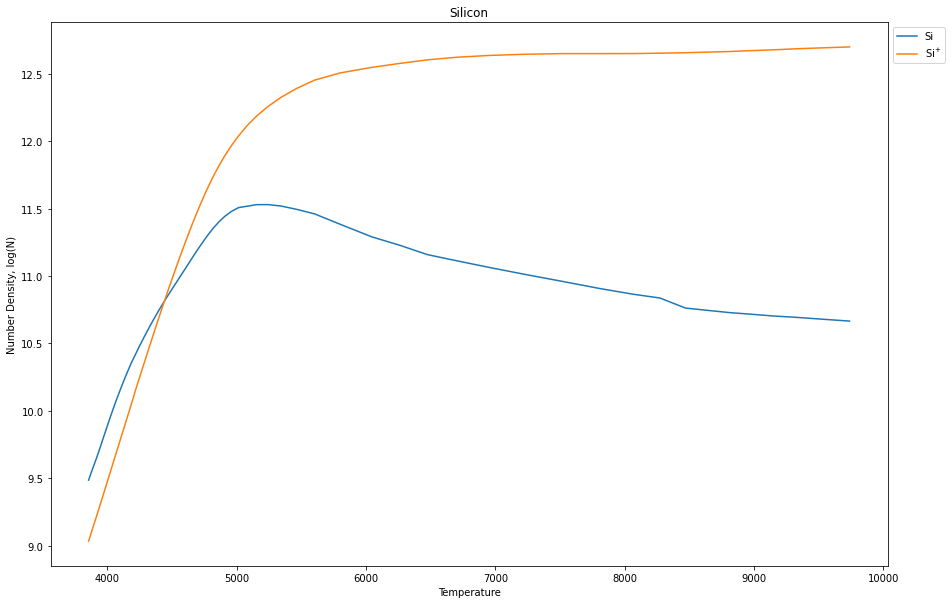

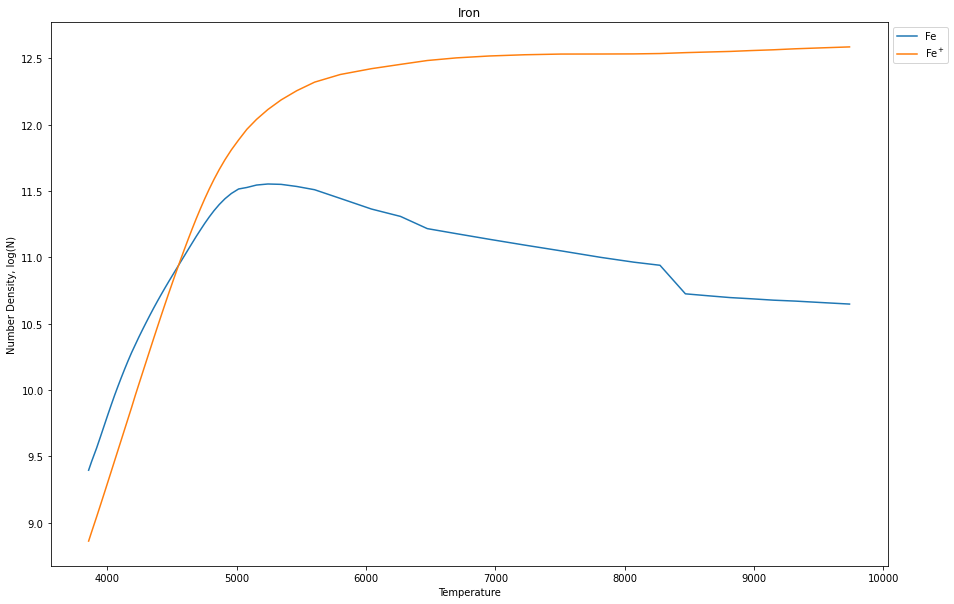

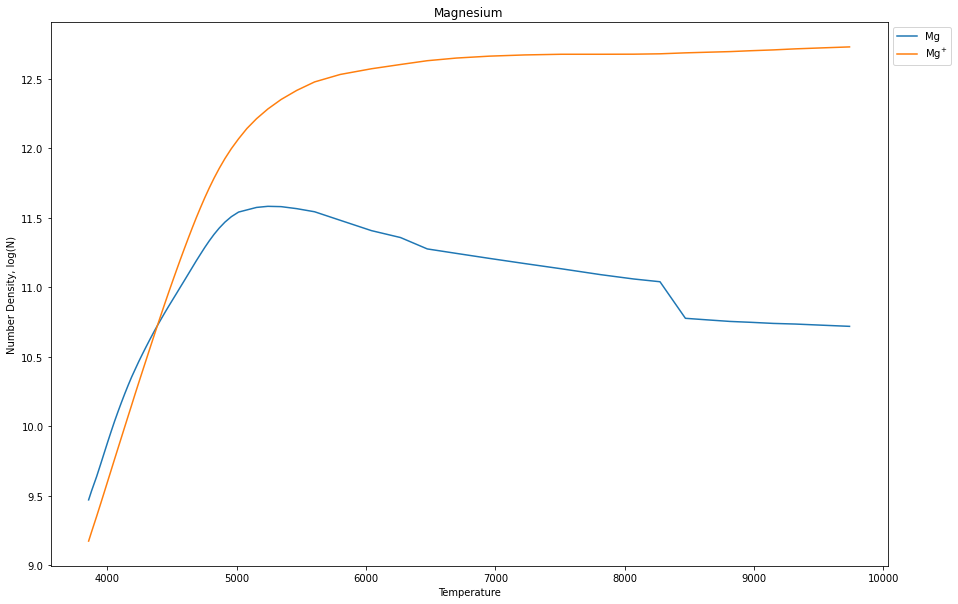

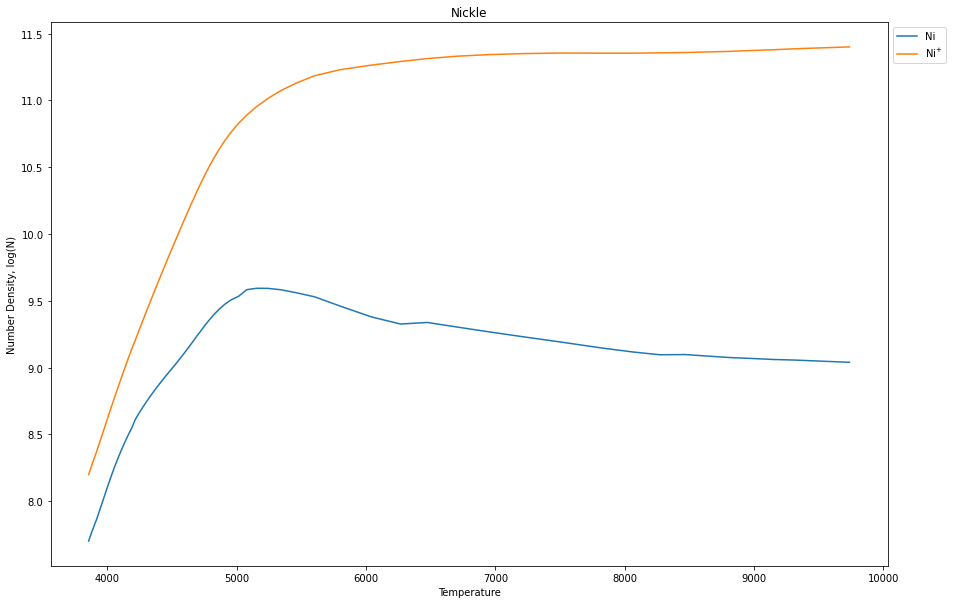

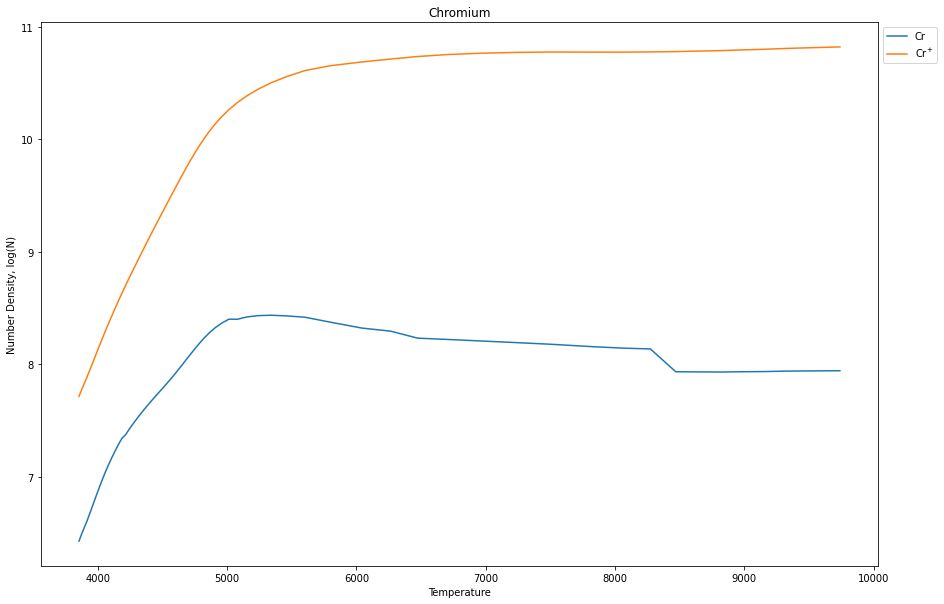

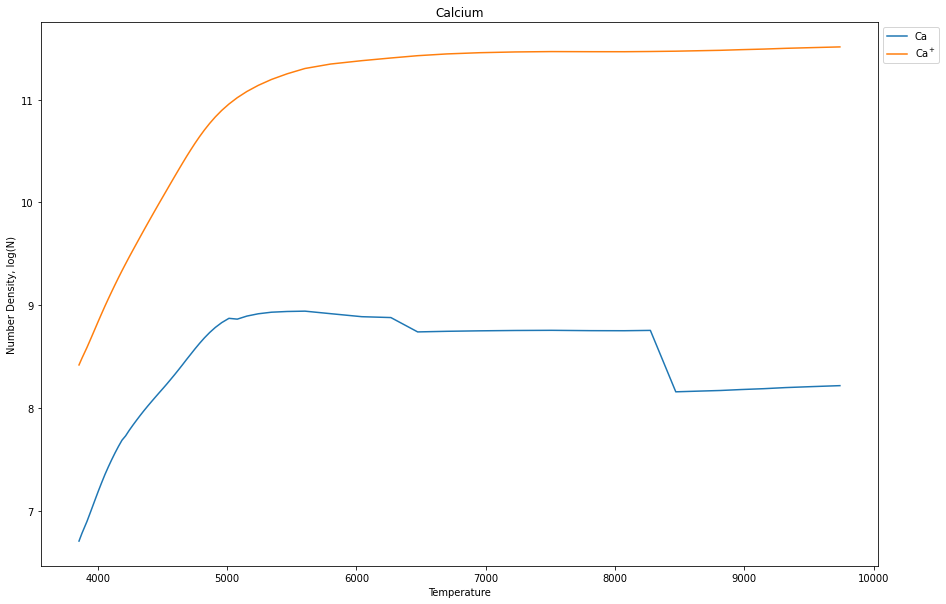

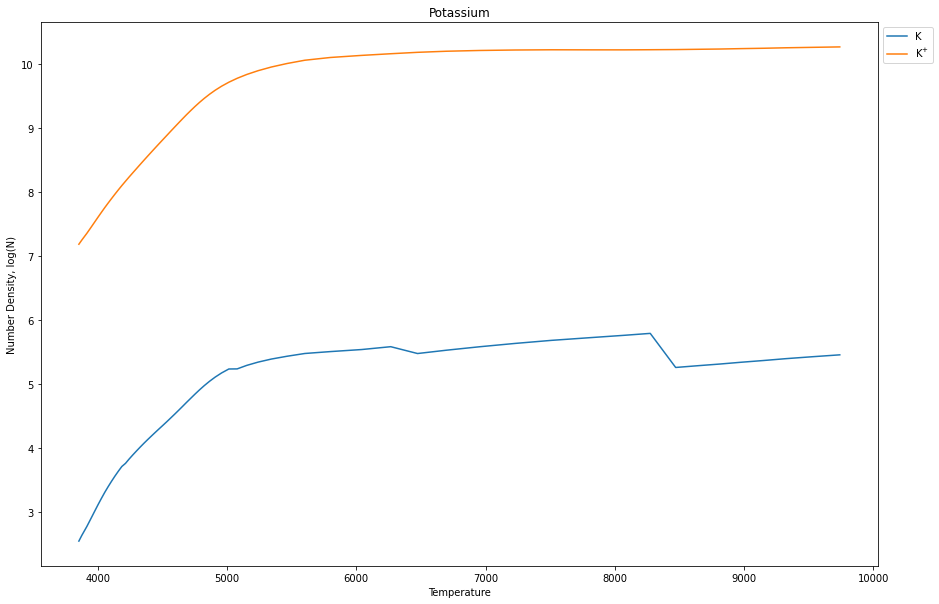

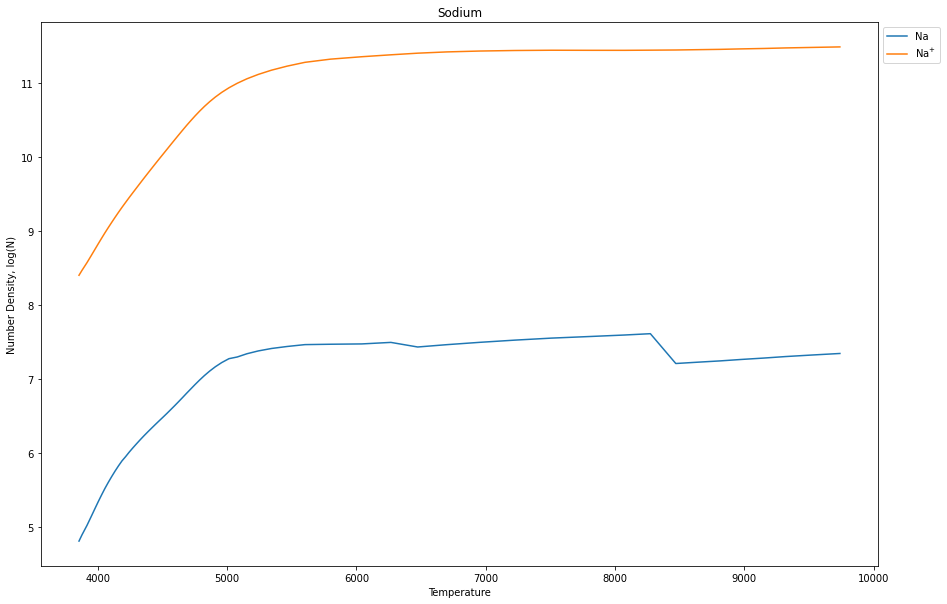

In [ ]:
for element in abundance.keys():
  if element != 'He' and element!= 'H':
    N = N_element[element]
    N_neutral = []
    N_plus = []
    for i in range(len(temps)):
      theta = 5040 / temps[i]
      phi = 0.6665 * get_partition_fn(element, theta) / get_partition_fn(element + '+', theta) \
      * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential[element])
      n = N[i] / (1 + phi / P_es[i])
      N_neutral.append(n)
      N_plus.append(N[i] - n)
    log_N_neutral = [math.log10(n) for n in N_neutral]
    log_N_plus = [math.log10(n) for n in N_plus]
    plt.figure(figsize=[15, 10])
    plt.plot(temps, log_N_neutral)
    plt.plot(temps, log_N_plus)
    plt.legend([element, element + '$^{+}$'], bbox_to_anchor=(1, 1))
    plt.xlabel('Temperature')
    plt.ylabel('Number Density, log(N)')
    plt.title(element_name[element])

## Plot of number of density of e$^{-}$ (green) and H$^{-}$ (red) vs Temperature.

Text(0.5, 1.0, 'N vs T for e$^{-}$ and H$^{-}$')

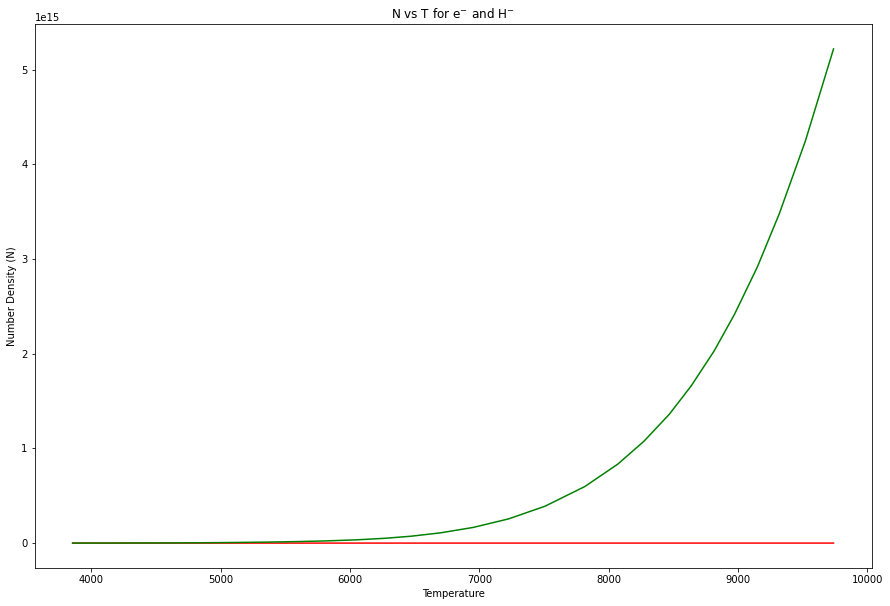

In [ ]:
plt.figure(figsize=[15, 10])
plt.plot(temps, N_H_minus, c='r')
plt.plot(temps, N_e, c='g')
plt.xlabel('Temperature')
plt.ylabel('Number Density (N)')
plt.title('N vs T for e$^{-}$ and H$^{-}$')

Text(0.5, 1.0, 'log(N) vs T for e$^{-}$ and H$^{-}$')

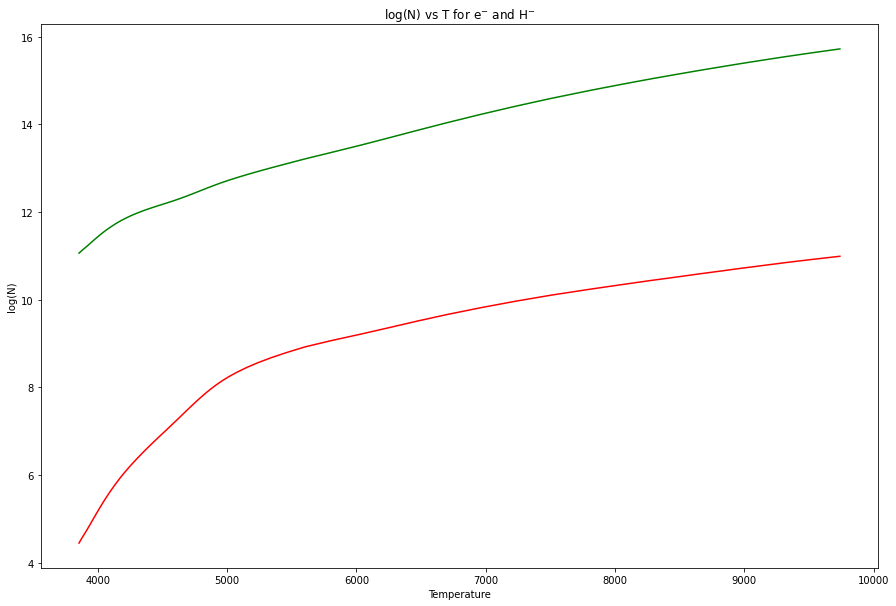

In [ ]:
plt.figure(figsize=[15, 10])
plt.plot(temps, log_N_H_minus, c='r')
plt.plot(temps, log_N_e, c='g')
plt.xlabel('Temperature')
plt.ylabel('log(N)')
plt.title('log(N) vs T for e$^{-}$ and H$^{-}$')

From the above graphs we can see that the number density of H$^{-}$ is significantly less when compared to the number density of e$^{-}$. We can say that H$^{-}$ doesn't significantly contribute to the e${^-}$ density.